In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [138]:
out_dirs = ['12x_120_merge_20220601_6fd6',
            '12x_120_merge_20220601_9d7c',
            '12x_120_merge_20220601_a116',
            '12x_120_merge_20220601_b2ca',
            '12x_120_merge_20220601_d4be',
            '12x_120_merge_20220602_5b8c',
            '12x_120_merge_20220602_aed8',
            
            '12x_complex_20220601_73e8',
            '12x_complex_20220601_7f73',
            '12x_complex_20220601_95ae',
            '12x_complex_20220601_e7d5',
            
            '12x_simple_20220601_15d3',
            '12x_simple_20220601_4779',

            '24x_120_merge_20220531_0f91',
            '24x_120_merge_20220531_1380',
            '24x_120_merge_20220531_1954',
            '24x_120_merge_20220531_d9e8',
            '24x_120_merge_20220531_e171',
            
            '24x_120_repl_20220531_7c07',
            '24x_120_repl_20220531_c98c',
            
            '24x_complex_20220601_9bda',
            '24x_complex_20220601_bd3f',
            '24x_complex_20220601_d12b',
            '24x_complex_20220601_e93c',
            '24x_complex_20220601_f805',
            
            '24x_simple_20220601_c188',
            '24x_simple_20220601_cf9d']


In [139]:
df = pd.DataFrame(columns=['resolution', 'type', 'path', 'legacy'])

for out_dir in out_dirs:
    out_spl = out_dir.split('_')
    res, run_type = out_spl[0], out_spl[-3]
    legacy = True if res == '24x' and run_type == 'merge' else False
    df = pd.concat([df, pd.DataFrame.from_records([{'resolution': res, 
        'type': run_type, 'path': out_dir, 'legacy': legacy}])])
df = df.reset_index(drop=True)
df.head(2)


,resolution,type,path,legacy
0,12x,merge,12x_120_merge_20220601_6fd6,False
1,12x,merge,12x_120_merge_20220601_9d7c,False


In [140]:
df['training_r2'] = 0.
df['validation_r2'] = 0.
df['test_r2'] = 0.

df['training_loss'] = 0.
df['validation_loss'] = 0.
df['test_loss'] = 0.

df.head(2)

,resolution,type,path,legacy,training_r2,validation_r2,test_r2,training_loss,validation_loss,test_loss
0,12x,merge,12x_120_merge_20220601_6fd6,False,0.0,0.0,0.0,0.0,0.0,0.0
1,12x,merge,12x_120_merge_20220601_9d7c,False,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
import importlib

from src.vit_data import load_cd_data_12x64
from src.data_loader import ViTDataLoader
from src.vit_train import ViTTrainer, load_model_dir, load_model_config
from src.vit_data import load_cd_data_24x128

vit_data_24 = load_cd_data_24x128()
vit_data_12 = load_cd_data_12x64()

for index, row in df.iterrows():

    config = importlib.import_module(f"output.{row.path}.config")
    vit = load_model_config(config, legacy=row.legacy)
    
    if row.resolution == '24x':
        vit_data = vit_data_24
        
        if config.REPLICATE_MODE == 'channels':
            vit_data = load_cd_data_24x128(replicate_mode='channels')

    else:
        vit_data = vit_data_12

    dataloader = ViTDataLoader(vit_data, split_type=config.SPLIT_TYPE, split_arg=config.SPLIT_ARG)
    trainer = ViTTrainer(vit, config_name, dataloader, resume=True, resume_path=f"output/{row.path}")
    trainer.setup()
    device = trainer.device
    vit = trainer.vit
    vit.load_state_dict(torch.load(f'output/{row.path}/model.torch', 
                               map_location=torch.device('cpu')))
    
    trainer.compute_predictions_losses()

    df.loc[index, 'training_r2'] = trainer.train_r2
    df.loc[index, 'validation_r2'] = trainer.validation_r2
    df.loc[index, 'test_r2'] = trainer.test_r2

    df.loc[index, 'training_loss'] = trainer.train_loss
    df.loc[index, 'validation_loss'] = trainer.validation_loss
    df.loc[index, 'test_loss'] = trainer.test_loss


Resuming from 18920...
Resuming from 18480...
Resuming from 9430...
Resuming from 9430...
Resuming from 9360...
Resuming from 12180...
Resuming from 9510...
Resuming from 19570...
Resuming from 19580...


In [106]:
df.head()

,resolution,type,path,legacy,training_r2,validation_r2,test_r2,training_loss,validation_loss,test_loss
0,12x,merge,12x_120_merge_20220601_6fd6,False,0.929346,0.930301,0.347738,0.071355,0.072388,0.602516
1,12x,merge,12x_120_merge_20220601_9d7c,False,0.938415,0.934673,0.387166,0.062142,0.067905,0.565287
2,12x,merge,12x_120_merge_20220601_a116,False,0.925736,0.920558,0.303617,0.075465,0.081998,0.640939
3,12x,merge,12x_120_merge_20220601_b2ca,False,0.909882,0.908494,0.372062,0.090914,0.096276,0.577969
4,12x,merge,12x_120_merge_20220601_d4be,False,0.936348,0.945013,0.399076,0.064754,0.056943,0.552800


In [141]:
df['epochs'] = 0
for index, row in df.iterrows():
    loss_df = pd.read_csv(f'output/{row.path}/loss.csv')
    epoch = loss_df.loc[loss_df.index.values[-1]].epoch.astype(int)
    df.loc[index, 'epochs'] = epoch

In [142]:
df['name'] = df['resolution'] + '_' + df['type']

0

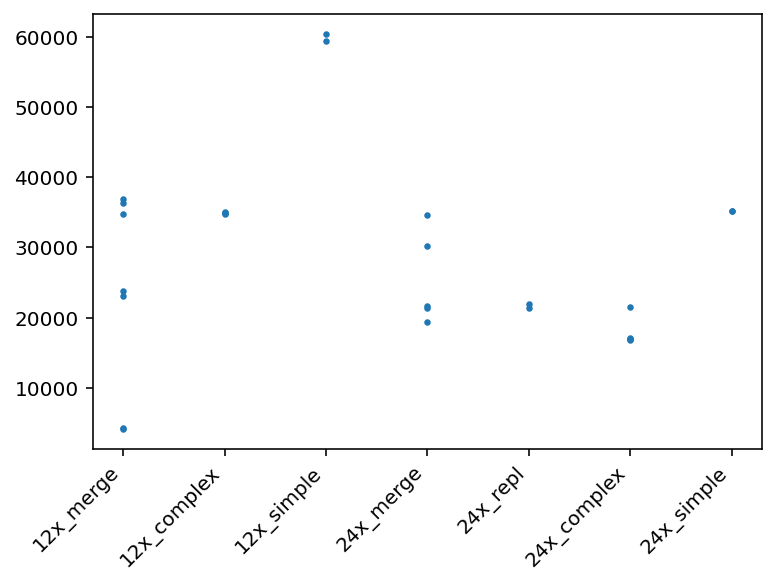

In [143]:
plt.scatter(df['name'], df['epochs'], s=5)
plt.xticks(df['name'].unique(), rotation=45, ha='right')
0


0

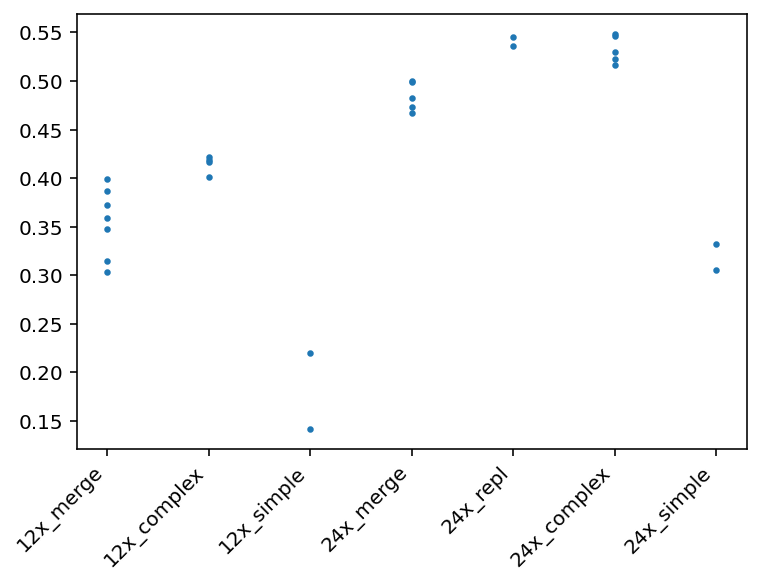

In [127]:
plt.scatter(df['name'], df['test_r2'], s=5)
plt.xticks(df['name'].unique(), rotation=45, ha='right')
0


0

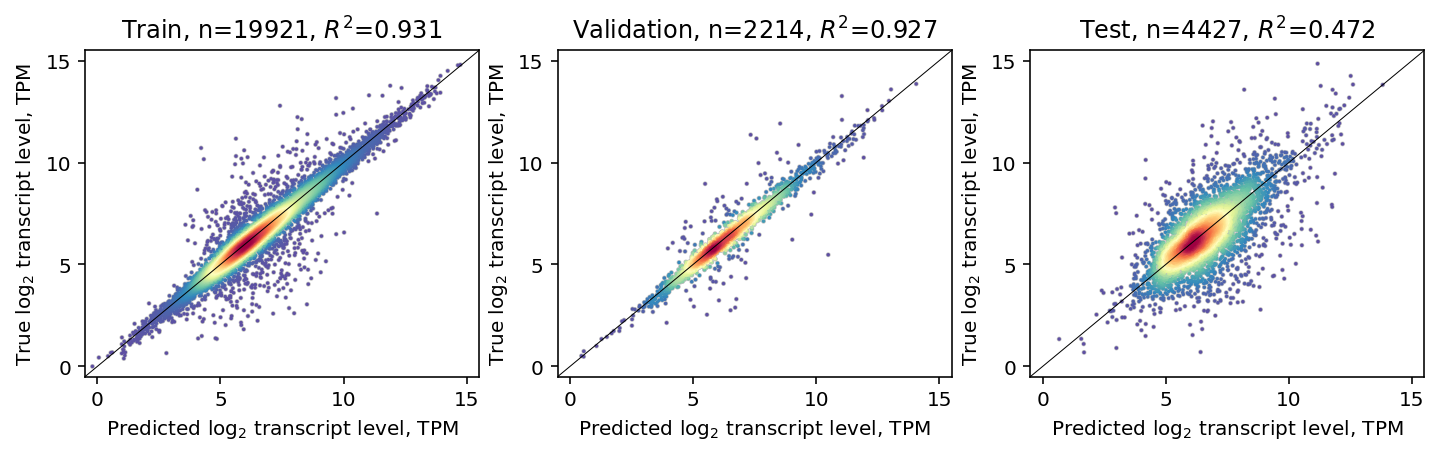

In [17]:
trainer.plot_predictions()
0

In [96]:
from src.rna_plotter import load_rna_plotter
from src.orf_plotter import ORFAnnotationPlotter

orf_plotter = ORFAnnotationPlotter()
rna_plotter = load_rna_plotter()

0

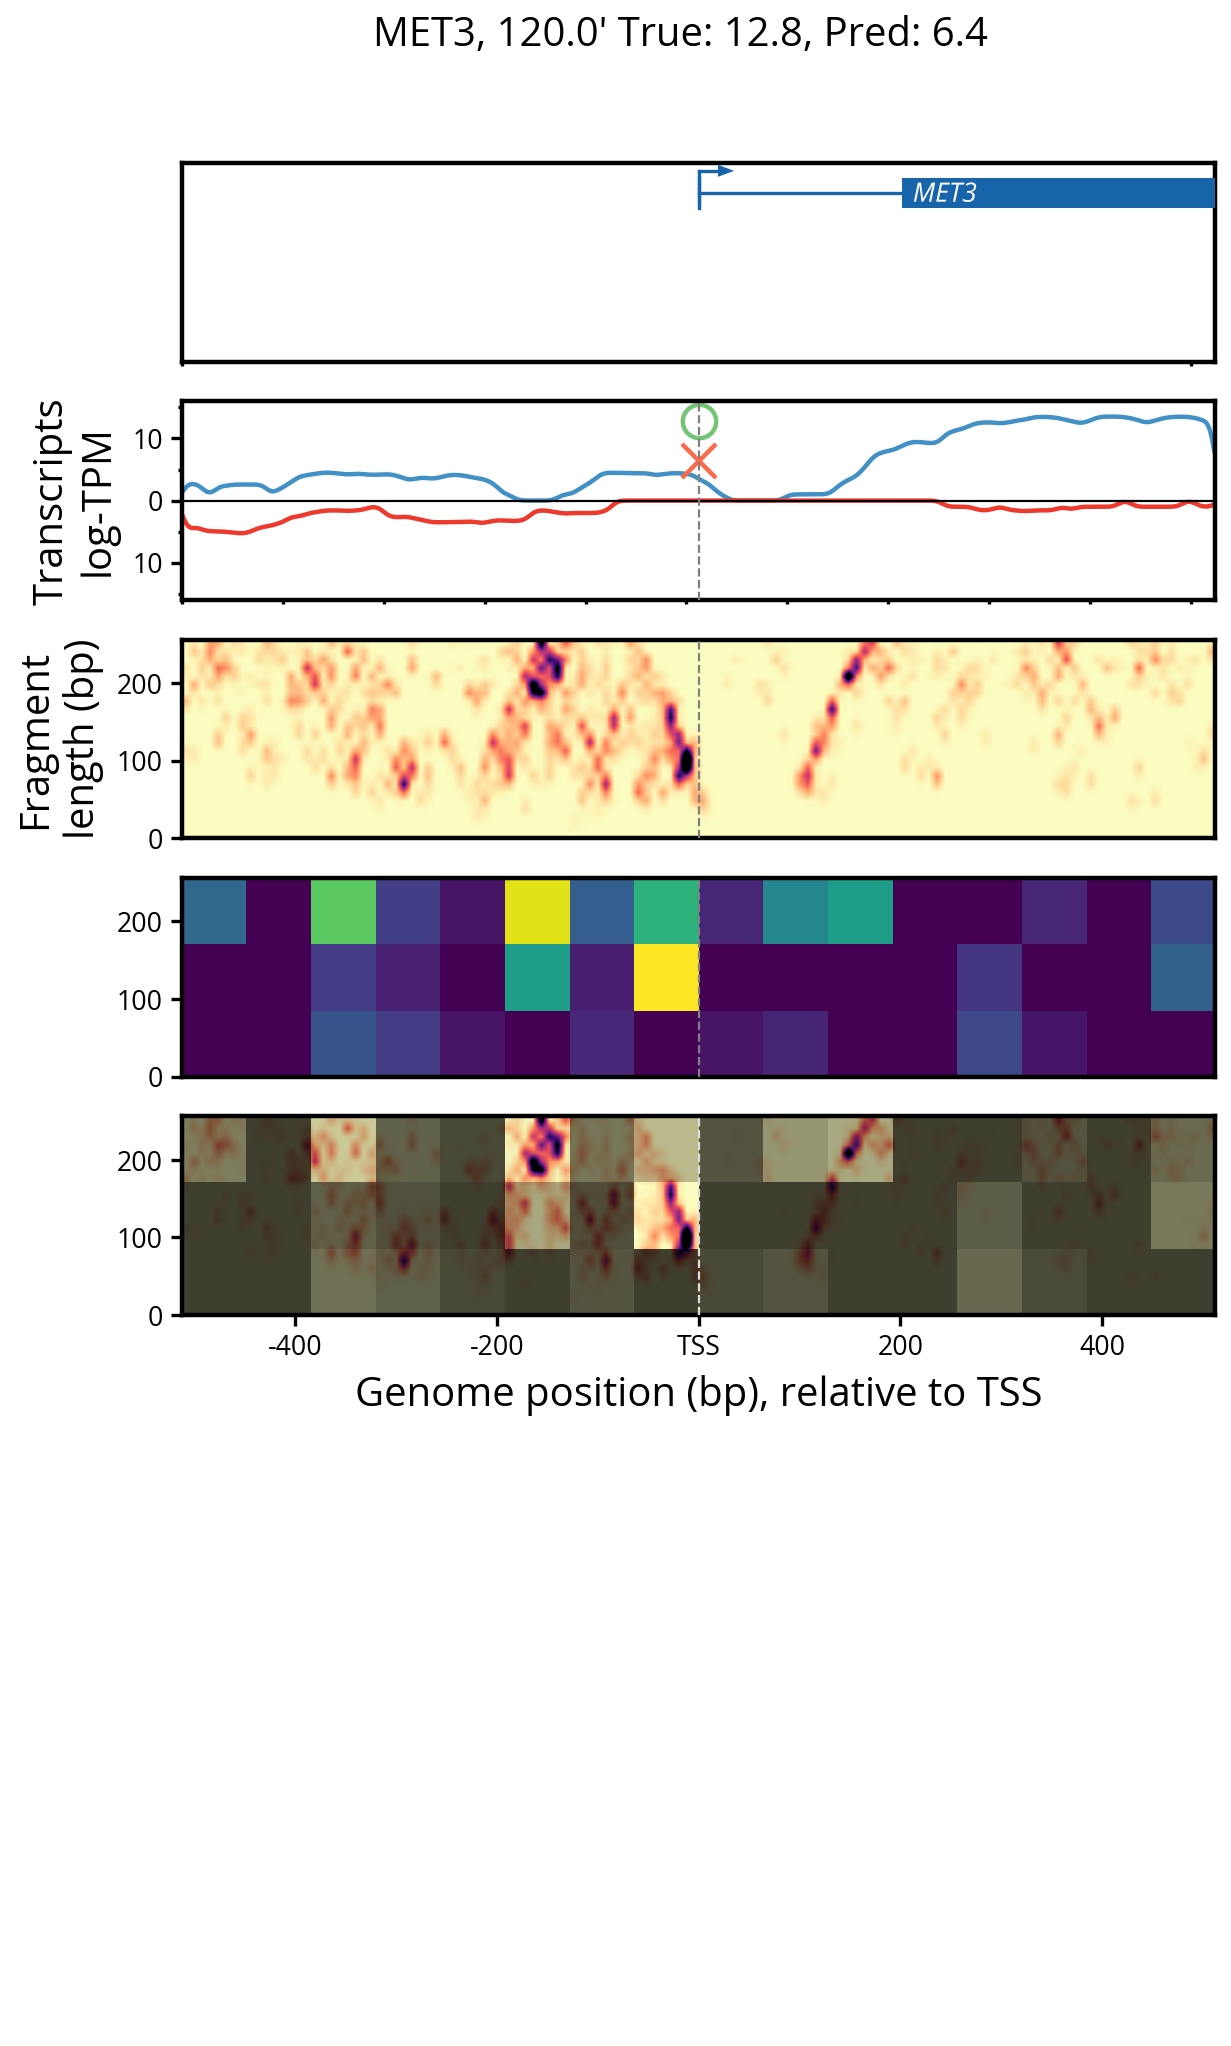

In [97]:
from src.vit_viz import plot_gene_prediction

plot_gene_prediction('MET3', 120.0, trainer.vit, trainer.dataloader.dataset,
    orf_plotter=orf_plotter, rna_plotter=rna_plotter)
0


In [87]:
from src.vit_data import load_cd_data_24x128

vit_data  = load_cd_data_24x128()

In [99]:
loss_df = pd.read_csv('output/complex_24x128_120_20220526_cf53/loss.csv')
loss_df.head()

,epoch,train_loss,validation_loss,debug_train,debug_valid,debug_test
0,10,1.020483,0.981446,1.018902,0.981318,0.925112
1,20,1.019321,0.981310,1.018632,0.981499,0.924843
2,30,1.018875,0.981141,1.018613,0.981477,0.924664
3,40,1.018471,0.981221,1.018572,0.981402,0.924801
4,50,1.018231,0.981416,1.018716,0.981446,0.924941


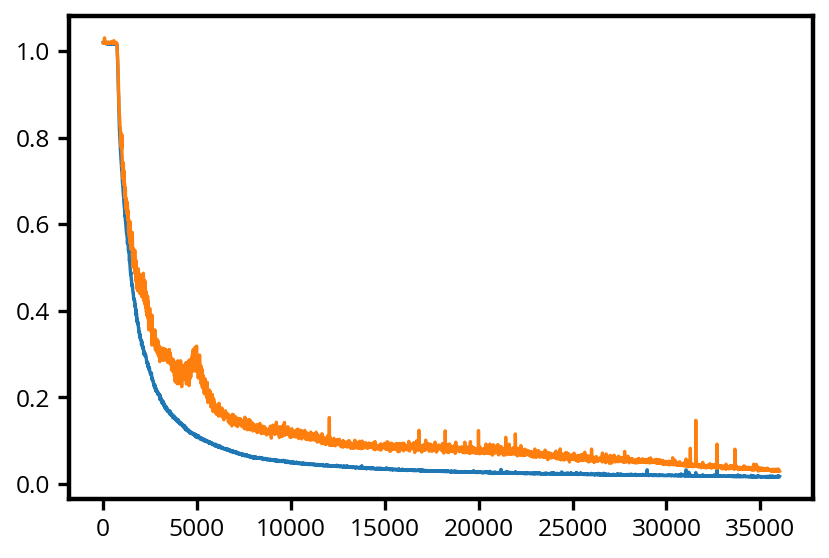

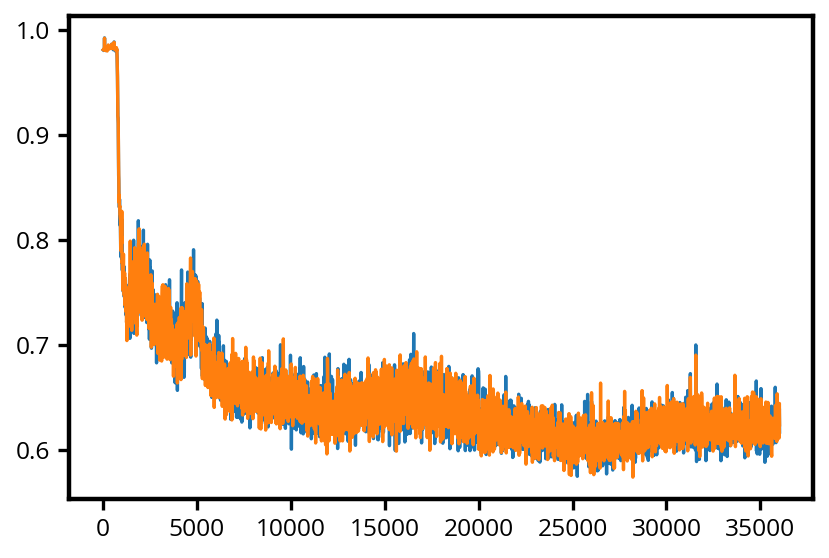

In [102]:
plt.plot(loss_df.epoch, loss_df.train_loss)
plt.plot(loss_df.epoch, loss_df.debug_train)
plt.show()

plt.plot(loss_df.epoch, loss_df.debug_valid)
plt.plot(loss_df.epoch, loss_df.validation_loss)